<a href="https://colab.research.google.com/github/gvigkannan/Awesome-SuperResolution/blob/master/COVID_Prediction_Qatar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division
import numpy as np
import time
import os 
import copy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import glob
import pandas as pd
import csv
from PIL import Image, ImageOps
import cv2
from collections import OrderedDict

In [ ]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision, torchsummary
from torchvision import datasets, models, transforms as T
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

In [ ]:
## XRay Vision Model
## Downloading Torch XRay vision Models
!pip install torchxrayvision
import torchxrayvision as xrv

## Drive and Random State

In [ ]:
## To access the drive files!
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def set_state(random_seed):
  np.random.seed(random_seed)
  torch.manual_seed(random_seed)
  

## Hyperparam


In [ ]:
## Hyperparams!
STEP_FLAG = False
EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 0.01
RANDOM_STATE = 0
MODEL_NAME = "_".join(("COVID_Fusic_RS"+str(RANDOM_STATE),"E"+str(EPOCHS),"Clf_v1"))
MODEL_PATH = "/content/drive/MyDrive/Models"
set_state(RANDOM_STATE)

In [ ]:
print(MODEL_NAME)

COVID_Fusic_RS0_E25_Clf_v1


In [ ]:
## Loading the dataset
IMG_DIR = "/content/drive/MyDrive/Dataset/COVID_Detection/DATA_300"
# data_fnames = os.listdir(IMG_DIR)
# use_cols = ['Filename', 
#             'BrixiaScoreGlobal']
#             # 'Brixia_RegionA', 
#             # 'Brixia_RegionB', 
#             # 'Brixia_RegionC', 
#             # 'Brixia_RegionD', 
#             # 'Brixia_RegionE', 
#             # 'Brixia_RegionF']
# annot_train = pd.read_csv("/content/drive/MyDrive/Dataset/brixia_raw_monochrome_306/BRIXIA_RAW_MONOCRHOME_RS0_train_v1.csv", usecols = use_cols)
# annot_test = pd.read_csv("/content/drive/MyDrive/Dataset/brixia_raw_monochrome_306/BRIXIA_RAW_MONOCRHOME_RS0_test_v1.csv", usecols = use_cols)
# annot_val = pd.read_csv("/content/drive/MyDrive/Dataset/brixia_raw_monochrome_306/BRIXIA_RAW_MONOCRHOME_RS0_val_v1.csv", usecols = use_cols)

In [ ]:
train_dir = os.path.join(IMG_DIR, "train")
val_dir = os.path.join(IMG_DIR, "val")
test_dir = os.path.join(IMG_DIR, "test")

transforms = T.Compose([T.Resize(size = (224, 224)), T.Grayscale(), T.ToTensor()])
# print(train_dir)
train_data = ImageFolder(root = train_dir, transform = transforms)
train_dl = DataLoader(train_data, BATCH_SIZE, shuffle = True, num_workers = 4)

val_data = ImageFolder(root = val_dir, transform = transforms)
val_dl = DataLoader(val_data, BATCH_SIZE, shuffle = True, num_workers = 4)

test_data = ImageFolder(root = test_dir, transform = transforms)
test_dl = DataLoader(test_data, BATCH_SIZE, shuffle = True, num_workers = 4)

In [ ]:
# img, label = next(iter(val_dl))
# torch.max(img) ## Already normalized!

In [ ]:
img_datasets = {x: datasets.ImageFolder(os.path.join(IMG_DIR, x), transform = transforms) for x in ['train', 'val']}
dataloaders = {x: DataLoader(img_datasets[x], BATCH_SIZE, shuffle = True, num_workers = 4) for x in ['train', 'val']}
dataset_sizes = {x: len(img_datasets[x]) for x in ['train', 'val']}
class_names = img_datasets['train'].classes

In [ ]:
next(iter(val_dl))

[tensor([[[[0.2941, 0.1490, 0.0549,  ..., 0.0196, 0.0196, 0.0157],
           [0.2549, 0.1216, 0.0431,  ..., 0.0196, 0.0196, 0.0157],
           [0.2431, 0.1176, 0.0431,  ..., 0.0196, 0.0196, 0.0157],
           ...,
           [0.1843, 0.1059, 0.0549,  ..., 0.0039, 0.0000, 0.0000],
           [0.2314, 0.1451, 0.0863,  ..., 0.0078, 0.0039, 0.0000],
           [0.2980, 0.2078, 0.1333,  ..., 0.0275, 0.0196, 0.0157]]],
 
 
         [[[0.1490, 0.1490, 0.1490,  ..., 0.1529, 0.1608, 0.1765],
           [0.1490, 0.1451, 0.1412,  ..., 0.1451, 0.1529, 0.1686],
           [0.1451, 0.1373, 0.1373,  ..., 0.1451, 0.1451, 0.1647],
           ...,
           [0.1333, 0.1255, 0.1255,  ..., 0.4314, 0.4078, 0.3725],
           [0.1333, 0.1255, 0.1255,  ..., 0.4314, 0.4078, 0.3725],
           [0.1333, 0.1294, 0.1294,  ..., 0.4157, 0.3922, 0.3608]]],
 
 
         [[[0.7137, 0.6902, 0.6392,  ..., 0.0157, 0.0157, 0.0118],
           [0.6784, 0.6275, 0.4784,  ..., 0.0118, 0.0118, 0.0078],
           [0.6039

## Model Related


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_brixia = xrv.models.DenseNet(weights = 'all')
for param in model_brixia.parameters():
  param.requires_grad = False
model_brixia.op_threshs = None
model_brixia.to(device)

XRV-DenseNet121-all

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
num_ftrs = model_brixia.classifier.in_features

In [ ]:
FFNN = nn.Sequential(
    nn.Linear(in_features = num_ftrs, out_features = 2))
FFNN.apply(init_weights)
model_brixia.classifier = FFNN.to(device)

In [ ]:
torchsummary.summary(model_brixia, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
      BatchNorm2d-11           [-1, 96, 56, 56]             192
             ReLU-12           [-1, 96, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]          12,288
      BatchNorm2d-14          [-1, 128,

In [ ]:
## To do: Training Script!
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, numEpochs):
  """ Simple Train Function for PyTorch Model. Adapted from PyTorch tutorials """
  start_time = time.time()

  best_WandB = copy.deepcopy(model.state_dict())
  best_loss = np.inf 
  best_acc = 0.0
  train_histLoss, val_histLoss = {}, {}
  train_histAcc, val_histAcc = {}, {}
  ## For all the epochs:
  for epoch in tqdm(range(numEpochs)):
    epoch_loss = 0.0
    start_epoch = time.time()
    if epoch % 15 == 0:
      print("*"*10)
      print("Epoch {}/{}".format(epoch + 1, numEpochs))
      print("*"*10)

    ## For each phase: train vs val
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      ## Tracking loss
      running_loss = 0.0
      running_accs = 0

      ## For all phase data:
      for imgs, labels in dataloaders[phase]:
        imgs = imgs.to(device)
        labels = labels.to(device)

        ## Zero the gradients
        optimizer.zero_grad()

        # ## Epoch Stats
        # epoch_loss += loss.item()

        ## Forward Prop
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(imgs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          ## Backward Prop
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        running_accs += torch.sum(preds == labels.data)
      if phase == 'train' and scheduler is not None:
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_accs.double() / dataset_sizes[phase]

      if phase == 'train':
        train_histLoss[epoch] = epoch_loss
        train_histAcc[epoch] = epoch_acc
      else:
        val_histLoss[epoch] = epoch_loss
        val_histAcc[epoch] = epoch_acc

      if epoch % 50 == 0:
        print("{}\tLoss: {:.4f}\tTime: {:.4f}".format(phase, epoch_loss, time.time() - start_epoch))
      ## Check for loss: ## We don't check for validation loss
      ## Need to write a function for rmse 


      if phase == 'val' and best_acc < epoch_acc:
        best_loss = epoch_loss
        best_acc = epoch_acc
        best_WandB = copy.deepcopy(model.state_dict())
        torch.save({
            'epoch': epoch,
            'loss': epoch_loss,
            'model_state': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, os.path.join(MODEL_PATH, MODEL_NAME+".pth"))
        print()
        print("Epoch: ", epoch)
        print("====> New Best Model!: {}".format(MODEL_NAME))
        print("Epoch Val Loss: {:.4f}".format(epoch_loss))
        print("Epoch Val Accs: {:.4f}".format(epoch_acc))
        print()
        print("*"*10)

  ## Loading best model
  print("Best MSE: {:.4f}".format(best_loss))
  print("Total Time: {:.4f}".format(time.time() - start_time)) 
  
  model.load_state_dict(best_WandB)
  return model, train_histLoss, val_histLoss, train_histAcc, val_histAcc




In [ ]:
EPOCHS = 150
MODEL_NAME = "_".join(("COVID_Qatar_RS"+str(RANDOM_STATE),"E"+str(EPOCHS),"BS"+str(BATCH_SIZE), "Clf_0Layers_WeightReg_v1"))
FLAG = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_brixia.parameters(), lr = LEARNING_RATE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if FLAG ==  0:
  lr_scheduler = optim.lr_scheduler.StepLR(optimizer, gamma = 0.1, step_size = 10)
else:
  lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_dl), eta_min=0.0)
print(MODEL_NAME)

COVID_Qatar_RS0_E150_BS128_Clf_0Layers_WeightReg_v1


In [ ]:
## TODO: Tensorboard Visualization!
## 100 Epochs: 5 mins
model_brixia.to(device)
model_brixia, train_losses, val_losses, train_accs, val_accs = train_model(model_brixia,
                                                                     criterion, 
                                                                     optimizer, 
                                                                     None, 
                                                                     dataloaders, 
                                                                     dataset_sizes, 
                                                                     EPOCHS)

**********
Epoch 1/150
**********
train	Loss: 0.4941	Time: 2.0882
val	Loss: 1.2165	Time: 3.3151

Epoch:  0
====> New Best Model!: COVID_Qatar_RS0_E150_BS128_Clf_0Layers_WeightReg_v1
Epoch Val Loss: 1.2165
Epoch Val Accs: 0.5000

**********

Epoch:  3
====> New Best Model!: COVID_Qatar_RS0_E150_BS128_Clf_0Layers_WeightReg_v1
Epoch Val Loss: 2.7464
Epoch Val Accs: 0.5050

**********

Epoch:  8
====> New Best Model!: COVID_Qatar_RS0_E150_BS128_Clf_0Layers_WeightReg_v1
Epoch Val Loss: 2.9999
Epoch Val Accs: 0.5100

**********

Epoch:  9
====> New Best Model!: COVID_Qatar_RS0_E150_BS128_Clf_0Layers_WeightReg_v1
Epoch Val Loss: 2.8674
Epoch Val Accs: 0.5200

**********
**********
Epoch 16/150
**********
**********
Epoch 31/150
**********
**********
Epoch 46/150
**********
train	Loss: 0.0100	Time: 1.8741
val	Loss: 4.7824	Time: 2.9420
**********
Epoch 61/150
**********
**********
Epoch 76/150
**********
**********
Epoch 91/150
**********
train	Loss: 0.0040	Time: 1.8487
val	Loss: 5.9977	Time: 2

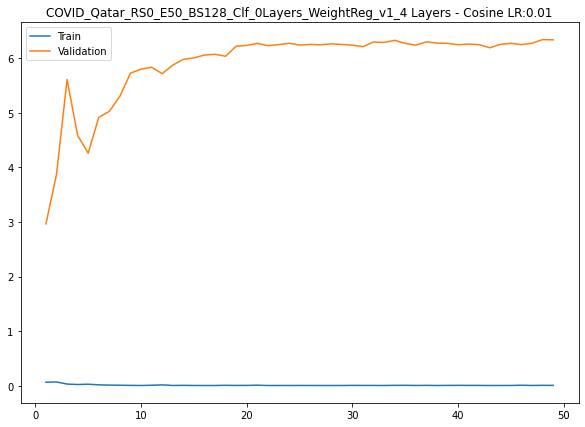

In [ ]:
plt.figure(figsize = (10,7))
lists = sorted(train_losses.items())
train_epoch, train_loss = zip(*lists[1:])
lists = sorted(val_losses.items())
val_epoch, val_loss = zip(*lists[1:])
plt.plot(train_epoch, train_loss, label = 'Train')
plt.plot(val_epoch, val_loss, label = 'Validation')
plt.title(MODEL_NAME+"_4 Layers - Cosine LR:"+str(LEARNING_RATE))
plt.legend()

In [ ]:
train_acc

(tensor(0.9901, device='cuda:0', dtype=torch.float64),
 tensor(0.9671, device='cuda:0', dtype=torch.float64),
 tensor(0.9885, device='cuda:0', dtype=torch.float64),
 tensor(0.9868, device='cuda:0', dtype=torch.float64),
 tensor(0.9885, device='cuda:0', dtype=torch.float64),
 tensor(0.9951, device='cuda:0', dtype=torch.float64),
 tensor(0.9852, device='cuda:0', dtype=torch.float64),
 tensor(0.9901, device='cuda:0', dtype=torch.float64),
 tensor(0.9868, device='cuda:0', dtype=torch.float64),
 tensor(0.9918, device='cuda:0', dtype=torch.float64),
 tensor(0.9885, device='cuda:0', dtype=torch.float64),
 tensor(0.9984, device='cuda:0', dtype=torch.float64),
 tensor(0.9967, device='cuda:0', dtype=torch.float64),
 tensor(0.9918, device='cuda:0', dtype=torch.float64),
 tensor(0.9984, device='cuda:0', dtype=torch.float64),
 tensor(1., device='cuda:0', dtype=torch.float64),
 tensor(0.9901, device='cuda:0', dtype=torch.float64),
 tensor(1., device='cuda:0', dtype=torch.float64),
 tensor(0.9984, de

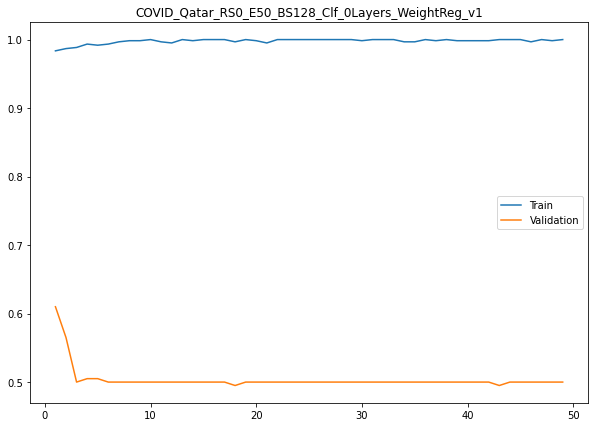

In [ ]:
plt.figure(figsize = (10,7))
lists = sorted(train_accs.items())
train_epoch, train_acc = zip(*lists[1:])
lists = sorted(val_accs.items())
val_epoch, val_acc = zip(*lists[1:])
plt.plot(train_epoch, train_acc, label = 'Train')
plt.plot(val_epoch, val_acc, label = 'Validation')
plt.title(MODEL_NAME)
plt.legend()

In [ ]:
def eval_model(model, criterion, eval_loader):
  """ Simple Train Function for PyTorch Model. Adapted from PyTorch tutorials """
  start_time = time.time()
  loss_hist = {}
  model.eval()

  ## Tracking loss
  eval_loss = 0.0
  eval_accs = 0.0
  ## For Evaluation Data:
  for imgs, labels in eval_loader:
      imgs = imgs.to(device)
      labels = labels.to(device)

      ## Zero the gradients
      optimizer.zero_grad()
      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      eval_loss += loss.item() * imgs.size(0)
      eval_accs += torch.sum(preds == labels.data)

    
   

  eval_loss = eval_loss / len(eval_loader.dataset)
  eval_acc = eval_accs.double() / len(eval_loader.dataset)
  print("Loss: {:.4f}".format(eval_loss))
  print("Acc: {:.4f}".format(eval_acc))
  print("Time: {:.4f}".format(time.time() - start_time))

  return eval_loss, eval_acc




In [ ]:
eval_model(model_brixia, criterion, test_dl)

Loss: 2.9973
Acc: 0.4900
Time: 1.1232


(2.9972612380981447, tensor(0.4900, device='cuda:0', dtype=torch.float64))

In [ ]:
eval_model(model_brixia, criterion, train_dl)

Loss: 0.0273
Acc: 0.9951
Time: 1.8673


(0.02729526926812373, tensor(0.9951, device='cuda:0', dtype=torch.float64))